# ML Training Notebook

## Setup

### Prepare venv!
Please restart VSCode and your kernel before selecting new venv as interpreter

In [1]:
%env PYTHONWARNINGS=ignore

env: PYTHONWARNINGS=ignore


In [2]:
# First off, probably best to run this to create a new virtual environment for you.
# This will also compile all of the .py modules I've written for access through Jupyter Notebooks.
# If you choose a different name other than the default please include it in your .gitignore file so it's not uploaded to Github
from pathlib import Path

def mk_venv(venv_name: str = '.venv'):
    root = Path.cwd().resolve()
    while not (root / '.git').exists():
        root = root.parent

    venv_path = root / venv_name
    if not Path(venv_path).exists():
        !python3 {root}/scripts/bootstrap_env.py {venv_path}
    return None

# Call it from here as one last namespace safety
mk_venv()

### Bring in dependencies

In [ ]:
# External dependencies...
#   specifically ML modules here
from sklearn.metrics import make_scorer, cohen_kappa_score, classification_report, mean_absolute_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, learning_curve

from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import RidgeClassifier
from mord import LogisticIT, LogisticAT
from lightgbm import LGBMRegressor

#   other important externals
from sqlalchemy import create_engine
from contextlib import redirect_stderr, contextmanager
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
import json
import ast
import os

#   my helper libraries
from core import get_settings, find_root
from ml_lib import ExperimentLogger, InspectionPrep
from ETL.extractors.sql_db import FromInspectionDB

### Run First Pipeline to save data to postgres

In [4]:
cfg = get_settings()
try:
    eng = create_engine(cfg.engine_uri).connect().close()
except:
    !python3 {cfg.root}/scripts/run_etl.py get_data

### And now extract from Postgres

In [5]:
df = FromInspectionDB().extract()

## Preprocessing

### Check unique values and bin below threshold values

In [6]:
df.nunique()

id                    265315
camis                  26695
boro                       5
zipcode                  218
cuisine                   89
inspection_date         1480
inspection_type            9
inspection_subtype         6
violation_code           124
action                     5
critical_flag              3
score                    139
census_tract            1175
nta                      193
latitude               14028
longitude              13469
dtype: int64

In [7]:
def binning_cats(df: pd.DataFrame, col: str, min: int) -> None:
    vals_to_replace = [i[0] for i in df[col].value_counts().items() if i[1] < min]
    df[col] = df[col].replace(vals_to_replace, 'other')
    return None

### Cleaning Bulk

#### Bin categories & create calculated fields

In [8]:
binning_cats(df, 'zipcode', 1000)
binning_cats(df, 'census_tract', 650)
binning_cats(df, 'violation_code', 100)
binning_cats(df, 'cuisine', 300)
binning_cats(df, 'nta', 750)

df[['zipcode', 'census_tract']] = df[['zipcode', 'census_tract']].astype(str)

df.sort_values(['camis', 'inspection_date'], inplace = True)

df['last_score'] = df.groupby('camis')['score'].shift(1)
df['rolling_mean_3'] = (
    df
        .groupby('camis')['score']
        .shift(1)
        .rolling(3)
        .mean()
        .reset_index(0, drop = True)
)

group_mean = df.groupby('camis')['score'].transform('mean')
df['last_score'] = df['last_score'].fillna(group_mean)
df['rolling_mean_3'] = df['rolling_mean_3'].fillna(group_mean)

#### Parse Date to create cyclical metrics

In [9]:
df['year']          = df['inspection_date'].dt.year
df['month']         = df['inspection_date'].dt.month
df['dow']           = df['inspection_date'].dt.weekday
df['quarter']       = df['inspection_date'].dt.quarter

df['is_weekend']    = df['dow'].isin([5, 6]).astype(int)

tau = 2 * np.pi
df['dow_sin'] = np.sin(tau * df['dow'] / 7)
df['dow_cos'] = np.cos(tau * df['dow'] / 7)

df['month_sin'] = np.sin(tau * (df['month'] - 1) / 12)
df['month_cos'] = np.cos(tau * (df['month'] - 1) / 12)

df['quart_sin'] = np.sin(tau * (df['quarter'] - 1) / 4)
df['quart_cos'] = np.cos(tau * (df['quarter'] - 1) / 4)

#### Drop useless columns after parsing - Bin Targets for ordinal classification

In [10]:
df.drop(columns = ['id', 'month', 'dow', 'quarter', 'camis', 'latitude', 'longitude'], inplace = True)

bins = [-1, 13, 27, float('inf')]
labels = [0, 1, 2]  # A=0, B=1, C=2
df['grade'] = pd.cut(df['score'], bins = bins, labels = labels).astype(int)
df.drop(columns = ['score'], inplace = True)

## Auto-Tuning

### Split via a hard date for testing with hold-out set

In [11]:
# Create hold out set
cutoff_date = pd.to_datetime('2025-02-17')
training_df = df[df['inspection_date'] <  cutoff_date]
testing_df  = df[df['inspection_date'] >= cutoff_date]

X_tr_full = training_df.drop(columns = ['inspection_date', 'grade'])
y_tr_full = training_df['grade']

es_split = int(len(X_tr_full) * 0.9)
X_tr, X_es = X_tr_full.iloc[:es_split], X_tr_full.iloc[es_split:]
y_tr, y_es = y_tr_full.iloc[:es_split], y_tr_full.iloc[es_split:]

X_te = testing_df.drop(columns = ['inspection_date', 'grade'])
y_te = testing_df['grade']

### Create transformer to save on space & prep pipeline

#### Custom Wrapper for LGBMRegressor

In [12]:
class LGBMOrdinal(LGBMRegressor):
    def predict(self, X):
        raw = super().predict(X)
        return np.clip(np.round(raw), 0, 2).astype(int)

In [13]:
numeric_feats = ['last_score', 'rolling_mean_3']
cyclical_feats = ['dow_sin', 'dow_cos', 'month_sin', 'month_cos', 'quart_sin', 'quart_cos']
categorical_feats = [
    'boro', 'zipcode', 'cuisine', 'inspection_type', 
    'inspection_subtype', 'violation_code', 'action', 
    'critical_flag', 'census_tract', 'nta', 'year', 'is_weekend'
    ]

ml_prep = ColumnTransformer(
    [
        ('num', StandardScaler(), numeric_feats),
        ('cyc', 'passthrough', cyclical_feats),
        ('cat', OneHotEncoder(handle_unknown = 'ignore'), categorical_feats),
    ],
)

ml_pipe = Pipeline(
    [
        ('prep', ml_prep),
        ('clf', LogisticIT())
    ]
)

In [14]:
# 2) Construct a param_grid as a *list* of dicts.
#    Each dict “overrides” the `clf` step and lists its own hyper-parameters.

# Classic ordinal grids, no fit method parameters required
grid_a = [
    # --- ordinal logistic models ---
    {
        'clf':                  [LogisticIT(), LogisticAT()],
        'clf__alpha':           [0.01, 0.1],
        'clf__max_iter':        [500],
    },
    # --- random forest baseline ---
    {
        'clf':                  [RandomForestClassifier(random_state = 42)],
        'clf__n_estimators':    [250],
        'clf__max_depth':       [5, 10],
        'clf__min_samples_leaf':[1, 3],
        'clf__class_weight':    ['balanced'],
    },
    # --- gradient-boosting regressor + round-to-ordinal trick ---
    {
        'clf':                  [LGBMOrdinal(random_state = 42, verbosity = -1)],
        'clf__n_estimators':    [200],
        'clf__max_depth':       [3, 5],
        'clf__learning_rate':   [0.05, 0.1],
        'clf__reg_lambda':      [0.1, 1],
    },
]

kappa_scorer = make_scorer(cohen_kappa_score, weights = 'quadratic')

### BoilerPlate Functions for Grid Searching

In [15]:
# Boiler plate for warning supression
@contextmanager
def suppress_warnings():
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        with open(os.devnull, 'w') as devnull:
            with redirect_stderr(devnull):
                yield


def _get_clf_report(search_obj, X_te, y_te):
    with suppress_warnings():
        print(classification_report(y_te, search_obj.predict(X_te)))
    return None

def _get_est_scores(search_obj, X_te, y_te):
    with suppress_warnings():
        print(
            f'Best Params: {search_obj.best_params_}\n'
            f'Best Score: {search_obj.best_score_}\n'
            f'Test Accuracy: {search_obj.score(X_te, y_te)}'
        )
    return None

In [16]:
# More boiler plate to get scoring for best estimators and conversion from grid to dataframe
def full_est_report(search_obj, X_te, y_te):
    _get_clf_report(search_obj, X_te, y_te)
    _get_est_scores(search_obj, X_te, y_te)
    return None

def grid_to_pd(grid: GridSearchCV) -> pd.DataFrame:
    cols = [
        'params', 'mean_fit_time', 
        'std_fit_time', 'mean_score_time', 
        'std_score_time', 'mean_test_score', 
        'std_test_score', 'rank_test_score'
    ]
    df = pd.DataFrame(grid.cv_results_, columns = cols)
    full_params = pd.json_normalize(df['params'])
    clf = full_params.pop('clf')
    df['params'] = full_params.apply(lambda row: row.dropna().to_dict(), axis = 1)

    return pd.concat([clf, df], axis = 1).copy()

In [17]:
# After reading in CSV, use parse params to convert back into real object
def parse_params(cell: str) -> dict:
    if not isinstance(cell, str):
        return {}
    params = ast.literal_eval(cell)
    return params

# Expand df takes in a dataframe and applies parse_params and expands the dataframe
def expand_csv(file_name = 'grid_log.csv'):
    df = pd.read_csv(find_root() / file_name)
    df['params'] = df['params'].apply(parse_params)
    params = pd.json_normalize(df['params'])

    df.drop(columns = ['params'], inplace = True)
    return pd.concat([df, params], axis = 1)


def read_write_grid(search_grid: GridSearchCV, file_name = 'grid_log.csv', overwrite = False):
    path = find_root() / file_name
    df = grid_to_pd(search_grid)
    if not overwrite:
        if path.is_file():
            csv_df = pd.read_csv(path)
            csv_df['params'] = csv_df['params'].apply(parse_params)
            df = pd.concat([csv_df, df], axis = 0)
        df.to_csv(path, header = True, index = False)
    else:
        df.to_csv(path, header = True, index = False)
    return None

In [50]:
def full_scoring_metric(search_grid: GridSearchCV):
    best = getattr(search_grid, 'best_estimator_', search_grid)

    with suppress_warnings():
        cohen_scr = cohen_kappa_score(y_te, best.predict(X_te))
        train_acc = best.score(X_tr, y_tr)
        test_acc = best.score(X_te, y_te)
        y_pred_train = best.predict(X_tr)
        y_pred_test  = best.predict(X_te)

    print(f'Cohen Kappa Score: {cohen_scr}')
    print(f'Gen Gap (acc): {train_acc - test_acc}')
    print('MAE train:', mean_absolute_error(y_tr, y_pred_train))
    print('MAE test: ', mean_absolute_error(y_te,  y_pred_test))
    print('QWK (Cohen’s kappa) train:', cohen_kappa_score(y_tr, y_pred_train, weights='quadratic'))
    print('QWK test: ', cohen_kappa_score(y_te,  y_pred_test, weights='quadratic'))



def learning_curve_plot(search_grid: GridSearchCV):
    best = getattr(search_grid, 'best_estimator_', search_grid)
    with suppress_warnings():
        train_sizes, train_scores, val_scores = learning_curve(
            best, X_tr, y_tr, cv=5, train_sizes=[.1, .3, .5, .7, 1.0]
        )

    # learning_curve_df.plot.line(x = 'training_scores', y = 'val_scores')
    # Compute means and stds across folds
    train_mean = train_scores.mean(axis=1)
    train_std  = train_scores.std(axis=1)
    val_mean   = val_scores.mean(axis=1)
    val_std    = val_scores.std(axis=1)

    # Plot
    plt.fill_between(
        train_sizes, 
        train_mean - train_std,
        train_mean + train_std, 
        alpha=0.1
    )
    plt.fill_between(
        train_sizes, 
        val_mean   - val_std,
        val_mean   + val_std,   
        alpha=0.1
    )

    plt.plot(train_sizes, train_mean, label='Training score')
    plt.plot(train_sizes, val_mean,   label='Validation score')

    plt.xlabel('Number of training examples')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    return None

### Instantiate Grid Searching

#### Grid Searching with Classic Ordinal Classifications

In [19]:
# --- ordinal logistic models ---
mord_grid = {
        'clf':                  [LogisticIT(), LogisticAT()],
        'clf__alpha':           [0.01, 0.1, 1.0],
        'clf__max_iter':        [200, 500],
    }

kappa_scorer = make_scorer(cohen_kappa_score, weights = 'quadratic')

mord_search = GridSearchCV(
    ml_pipe,
    mord_grid,
    cv = TimeSeriesSplit(n_splits = 3),
    scoring = kappa_scorer,
    n_jobs = 7
)
mord_search.fit(X_tr, y_tr)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['last_score',
                                                                          'rolling_mean_3']),
                                                                        ('cyc',
                                                                         'passthrough',
                                                                         ['dow_sin',
                                                                          'dow_cos',
                                                                          'month_sin',
                                                                          'month_cos',
                                                                          'quart_sin',
                                                                          'quart_cos']),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['bo...
                                                                          'cuisine',
                                                                          'inspection_type',
                                                                          'inspection_subtype',
                                                                          'violation_code',
                                                                          'action',
                                                                          'critical_flag',
                                                                          'census_tract',
                                                                          'nta',
                                                                          'year',
                                                                          'is_weekend'])])),
                                       ('clf', LogisticIT())]),
             n_jobs=7,
             param_grid={'clf': [LogisticIT(), LogisticAT()],
                         'clf__alpha': [0.01, 0.1, 1.0],
                         'clf__max_iter': [200, 500]},
             scoring=make_scorer(cohen_kappa_score, response_method='predict', weights=quadratic))

In [ ]:
# read_write_grid(mord_search, overwrite = True)
# full_est_report(mord_search, X_te, y_te)

              precision    recall  f1-score   support

           0       0.75      0.88      0.81      6478
           1       0.75      0.61      0.67      5483
           2       0.88      0.87      0.88      9010

    accuracy                           0.81     20971
   macro avg       0.79      0.79      0.79     20971
weighted avg       0.81      0.81      0.80     20971

Best Params: {'clf': LogisticIT(), 'clf__alpha': 1.0, 'clf__max_iter': 500}
Best Score: 0.7809477537723098
Test Accuracy: 0.7924179716061936


In [ ]:
# expand_csv().sort_values('rank_test_score').head()

,clf,mean_fit_time,std_fit_time,mean_score_time,std_score_time,mean_test_score,std_test_score,rank_test_score,clf__alpha,clf__max_iter
5,LogisticIT(),51.624112,23.444444,0.666047,0.073551,0.780948,0.003675,1,1.00,500.0
4,LogisticIT(),19.893337,9.456943,0.578842,0.039329,0.780618,0.003996,2,1.00,200.0
2,LogisticIT(),16.847663,8.311080,0.453930,0.039370,0.779572,0.004887,3,0.10,200.0
3,LogisticIT(),46.954212,23.040459,0.572659,0.019367,0.779555,0.004755,4,0.10,500.0
1,LogisticIT(),42.207472,20.960021,0.540025,0.052829,0.779510,0.004833,5,0.01,500.0


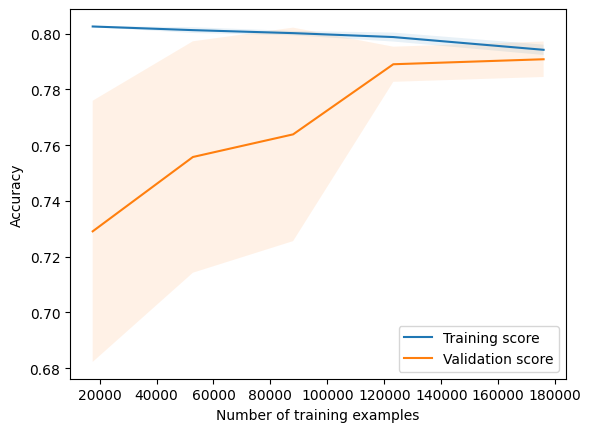

In [ ]:
# learning_curve_plot(mord_search)

#### Trying the grid again with improved metrics

In [23]:
# --- random forest baseline ---
randf_grid = {
        'clf':                  [RandomForestClassifier(random_state = 42)],
        'clf__n_estimators':    [100, 250, 500],
        'clf__max_depth':       [5, 10, 15],
        'clf__min_samples_leaf':[1, 3, 5, 7, 9],
        'clf__class_weight':    ['balanced'],
    }

randf_search = GridSearchCV(
    ml_pipe,
    randf_grid,
    cv = TimeSeriesSplit(n_splits = 3),
    scoring = kappa_scorer,
    n_jobs = 7
)
randf_search.fit(X_tr, y_tr)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['last_score',
                                                                          'rolling_mean_3']),
                                                                        ('cyc',
                                                                         'passthrough',
                                                                         ['dow_sin',
                                                                          'dow_cos',
                                                                          'month_sin',
                                                                          'month_cos',
                                                                          'quart_sin',
                                                                          'quart_cos']),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['bo...
                                                                          'census_tract',
                                                                          'nta',
                                                                          'year',
                                                                          'is_weekend'])])),
                                       ('clf', LogisticIT())]),
             n_jobs=7,
             param_grid={'clf': [RandomForestClassifier(random_state=42)],
                         'clf__class_weight': ['balanced'],
                         'clf__max_depth': [5, 10, 15],
                         'clf__min_samples_leaf': [1, 3, 5, 7, 9],
                         'clf__n_estimators': [100, 250, 500]},
             scoring=make_scorer(cohen_kappa_score, response_method='predict', weights=quadratic))

In [ ]:
# read_write_grid(randf_search)
# full_est_report(randf_search, X_te, y_te)

              precision    recall  f1-score   support

           0       0.84      0.79      0.81      6478
           1       0.79      0.81      0.80      5483
           2       0.90      0.93      0.92      9010

    accuracy                           0.85     20971
   macro avg       0.84      0.84      0.84     20971
weighted avg       0.85      0.85      0.85     20971

Best Params: {'clf': RandomForestClassifier(random_state=42), 'clf__class_weight': 'balanced', 'clf__max_depth': 15, 'clf__min_samples_leaf': 1, 'clf__n_estimators': 100}
Best Score: 0.8031860818270773
Test Accuracy: 0.8164694018932581


In [ ]:
# expand_csv().sort_values('rank_test_score').head()

,clf,mean_fit_time,std_fit_time,mean_score_time,std_score_time,mean_test_score,std_test_score,rank_test_score,clf__alpha,clf__max_iter,clf__class_weight,clf__max_depth,clf__min_samples_leaf,clf__n_estimators
5,LogisticIT(),51.624112,23.444444,0.666047,0.073551,0.780948,0.003675,1,1.0,500.0,NaN,NaN,NaN,NaN
42,RandomForestClassifier(random_state=42),47.389113,21.956024,1.486477,0.040118,0.803186,0.001159,1,NaN,NaN,balanced,15.0,1.0,100.0
43,RandomForestClassifier(random_state=42),113.630455,52.867783,3.056635,0.051516,0.799709,0.001003,2,NaN,NaN,balanced,15.0,1.0,250.0
4,LogisticIT(),19.893337,9.456943,0.578842,0.039329,0.780618,0.003996,2,1.0,200.0,NaN,NaN,NaN,NaN
2,LogisticIT(),16.847663,8.311080,0.453930,0.039370,0.779572,0.004887,3,0.1,200.0,NaN,NaN,NaN,NaN


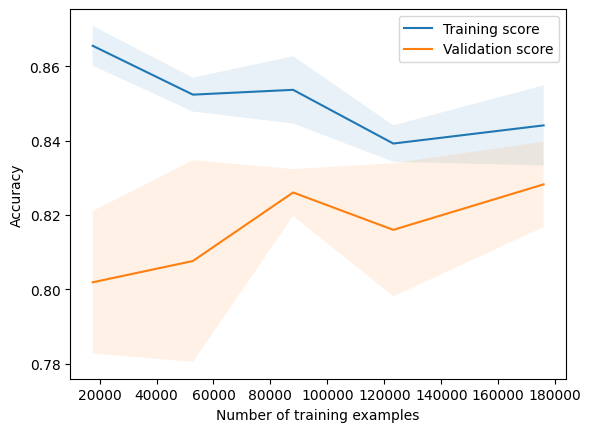

In [ ]:
# learning_curve_plot(randf_search)

### Focusing more on LGBMOrdinal - Finals

In [27]:
lgbm_grid = [
    # --- gradient-boosting regressor + round-to-ordinal trick ---
    {
        'clf':                          [LGBMOrdinal(random_state = 42, verbosity = -1)],
        'clf__n_estimators':            [100, 200, 300],
        'clf__max_depth':               [3, 5, 7, 9, 11],
        'clf__learning_rate':           [0.1, 1.0],
        'clf__reg_lambda':              [0.1, 1],
    },
]

lgbm_search = GridSearchCV(
    ml_pipe,
    lgbm_grid,
    cv = TimeSeriesSplit(n_splits = 3),
    scoring = kappa_scorer,
    n_jobs = 7
)
lgbm_search.fit(X_tr, y_tr)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['last_score',
                                                                          'rolling_mean_3']),
                                                                        ('cyc',
                                                                         'passthrough',
                                                                         ['dow_sin',
                                                                          'dow_cos',
                                                                          'month_sin',
                                                                          'month_cos',
                                                                          'quart_sin',
                                                                          'quart_cos']),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['bo...
                                                                          'critical_flag',
                                                                          'census_tract',
                                                                          'nta',
                                                                          'year',
                                                                          'is_weekend'])])),
                                       ('clf', LogisticIT())]),
             n_jobs=7,
             param_grid=[{'clf': [LGBMOrdinal(random_state=42, verbosity=-1)],
                          'clf__learning_rate': [0.1, 1.0],
                          'clf__max_depth': [3, 5, 7, 9, 11],
                          'clf__n_estimators': [100, 200, 300],
                          'clf__reg_lambda': [0.1, 1]}],
             scoring=make_scorer(cohen_kappa_score, response_method='predict', weights=quadratic))

In [ ]:
# read_write_grid(lgbm_search)
# full_est_report(lgbm_search, X_te, y_te)

              precision    recall  f1-score   support

           0       0.89      0.84      0.86      6478
           1       0.72      0.89      0.80      5483
           2       0.95      0.85      0.90      9010

    accuracy                           0.86     20971
   macro avg       0.85      0.86      0.85     20971
weighted avg       0.87      0.86      0.86     20971

Best Params: {'clf': LGBMOrdinal(random_state=42, verbosity=-1), 'clf__learning_rate': 0.1, 'clf__max_depth': 9, 'clf__n_estimators': 100, 'clf__reg_lambda': 0.1}
Best Score: 0.8265216639117039
Test Accuracy: 0.8476897664707512


In [ ]:
# full_scoring_metric(lgbm_search)

Cohen Kappa Score: 0.7847654113025659
Gen Gap (acc): -0.015878006339427375
MAE train: 0.18088845840779597
MAE test:  0.16541891183062324
QWK (Cohen’s kappa) train: 0.8361916802685926
QWK test:  0.8476897664707512


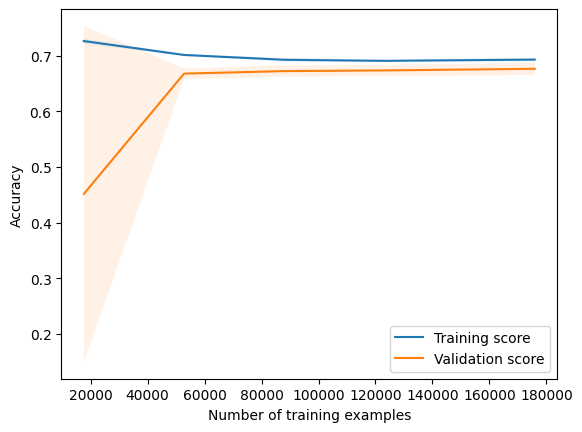

In [ ]:
# learning_curve_plot(lgbm_search)

### Analyze based on CSV Results

In [ ]:
# expand_csv().sort_values('rank_test_score').head()

,clf,mean_fit_time,std_fit_time,mean_score_time,std_score_time,mean_test_score,std_test_score,rank_test_score,clf__alpha,clf__max_iter,clf__class_weight,clf__max_depth,clf__min_samples_leaf,clf__n_estimators,clf__learning_rate,clf__reg_lambda
5,LogisticIT(),51.624112,23.444444,0.666047,0.073551,0.780948,0.003675,1,1.0,500.0,NaN,NaN,NaN,NaN,NaN,NaN
42,RandomForestClassifier(random_state=42),47.389113,21.956024,1.486477,0.040118,0.803186,0.001159,1,NaN,NaN,balanced,15.0,1.0,100.0,NaN,NaN
75,"LGBMOrdinal(random_state=42, verbosity=-1)",10.178966,1.430829,0.834163,0.041612,0.826522,0.004881,1,NaN,NaN,NaN,9.0,NaN,100.0,0.1,0.1
43,RandomForestClassifier(random_state=42),113.630455,52.867783,3.056635,0.051516,0.799709,0.001003,2,NaN,NaN,balanced,15.0,1.0,250.0,NaN,NaN
81,"LGBMOrdinal(random_state=42, verbosity=-1)",9.739799,0.686136,0.855736,0.034203,0.826405,0.005279,2,NaN,NaN,NaN,11.0,NaN,100.0,0.1,0.1


### Attempt Training Directly

In [37]:
with suppress_warnings():
    estimators = [
        ('logit', mord_search.best_estimator_),
        ('randf', randf_search.best_estimator_),
        ('lgbm', lgbm_search.best_estimator_)
    ]

    stack = StackingClassifier(
        estimators = estimators,
        final_estimator = RidgeClassifier(alpha = 1.0),
        cv = 5,
        passthrough = False
    )

    stack.fit(X_tr, y_tr)

/Users/neelagarwal/Projects/DataClassRepos/CurryInspection/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMOrdinal was fitted with feature names
  warnings.warn(
/Users/neelagarwal/Projects/DataClassRepos/CurryInspection/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMOrdinal was fitted with feature names
  warnings.warn(
/Users/neelagarwal/Projects/DataClassRepos/CurryInspection/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMOrdinal was fitted with feature names
  warnings.warn(
/Users/neelagarwal/Projects/DataClassRepos/CurryInspection/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMOrdinal was fitted with feature names
  warnings.warn(
/Users/neelagarwal/Projects/DataClas

StackingClassifier(cv=5,
                   estimators=[('logit',
                                Pipeline(steps=[('prep',
                                                 ColumnTransformer(transformers=[('num',
                                                                                  StandardScaler(),
                                                                                  ['last_score',
                                                                                   'rolling_mean_3']),
                                                                                 ('cyc',
                                                                                  'passthrough',
                                                                                  ['dow_sin',
                                                                                   'dow_cos',
                                                                                   'month_sin',
                                                                                   'month_cos',
                                                                                   'quart_sin',
                                                                                   'quart_cos']),
                                                                                 ('cat',
                                                                                  OneHotEncoder(handle_unknown='ignore'),
                                                                                  ['boro',
                                                                                   'zipcode',
                                                                                   'cuisine',
                                                                                   'inspection_type',
                                                                                   'inspect...
                                                                                   'month_cos',
                                                                                   'quart_sin',
                                                                                   'quart_cos']),
                                                                                 ('cat',
                                                                                  OneHotEncoder(handle_unknown='ignore'),
                                                                                  ['boro',
                                                                                   'zipcode',
                                                                                   'cuisine',
                                                                                   'inspection_type',
                                                                                   'inspection_subtype',
                                                                                   'violation_code',
                                                                                   'action',
                                                                                   'critical_flag',
                                                                                   'census_tract',
                                                                                   'nta',
                                                                                   'year',
                                                                                   'is_weekend'])])),
                                                ('clf',
                                                 LGBMOrdinal(max_depth=9,
                                                             random_state=42,
                                                             reg_lambda=0.1,
                                                             verbosity=-1))]))],
            

In [ ]:
with suppress_warnings():
    predict = stack.predict(X_te)

In [44]:
with suppress_warnings():
    print(stack.score(X_te, y_te))

0.8860330933193458


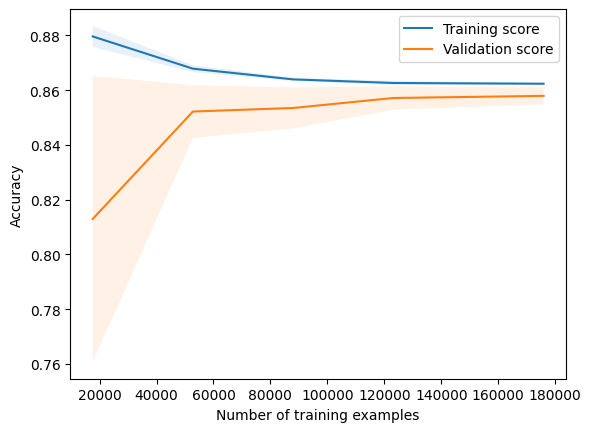

In [ ]:
# learning_curve_plot(stack)

In [51]:
full_scoring_metric(stack)

Cohen Kappa Score: 0.8244448907050863
Gen Gap (acc): -0.02359908652562659
MAE train: 0.17641388028684593
MAE test:  0.15807543750894093
QWK (Cohen’s kappa) train: 0.8204879726498917
QWK test:  0.83123312201157


In [52]:
import joblib

In [57]:
model_path = cfg.storage / 'curry_inspector_20250514_v1.joblib'
joblib.dump(stack, model_path)

['/Users/neelagarwal/Projects/DataClassRepos/CurryInspection/resources/curry_inspector_20250514_v1.joblib']